In [1]:
# ニューラルネットワークのモデルを作成するためのライブラリ
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping



# データ前処理のためのライブラリ
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# データ可視化のライブラリ
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline 


Using TensorFlow backend.


In [2]:
# 分析するデータはkaggleのTitanicデータセット(https://www.kaggle.com/c/titanic/data)を用いる

# CSVファイルの読み込み、パスは上記のファイルを置いたディレクトリを指定
train_set = pd.read_csv('data/titanic/train.csv')
test_set = pd.read_csv('data/titanic/test.csv')
sample_set = pd.read_csv('data/titanic/gender_submission.csv')

In [3]:
# 訓練データの確認
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# テストデータの確認、データフレームにないSurvivedを予測するのが目的
test_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# 後ほど提出するファイルに使用するためテストセットのIDをNumpy配列として切り出す
PassengerId = np.array(test_set['PassengerId']).astype(int)

In [6]:
# 欠損値の確認(訓練データ)
train_set.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
# 欠損値の確認(テストデータ)
test_set.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [8]:
# AgeとFareの欠損データを平均値で埋める
train_set['Age'] = train_set['Age'].fillna(train_set['Age'].mean())
test_set['Age'] = test_set['Age'].fillna(test_set['Age'].mean())
test_set['Fare'] = test_set['Fare'].fillna(test_set['Fare'].mean())

In [9]:
#欠損地を埋めるためにEmbarkedの最頻値を確認
train_set['Embarked'].mode()

0    S
dtype: object

In [10]:
#欠損地をEmbarkedの最頻値で埋める
train_set['Embarked'] = train_set['Embarked'].fillna('S')

In [11]:
# 不要な特徴量Name, Tichet, Fare, Cabinをドロップ
train_set = train_set.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'],axis=1)
test_set = test_set.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'],axis=1)

In [12]:
# カテゴリ変数であるPclass, Embarked, Sexをダミー変数へ変換

dummies = pd.get_dummies(train_set['Pclass'], drop_first=True, prefix='Pclass')
train_set = train_set.drop(columns='Pclass')
train_set = pd.merge(train_set, dummies, left_index=True, right_index=True)

dummies = pd.get_dummies(test_set['Pclass'], drop_first=True, prefix='Pclass')
test_set = test_set.drop(columns='Pclass')
test_set = pd.merge(test_set, dummies, left_index=True, right_index=True)

dummies = pd.get_dummies(train_set['Embarked'], drop_first=True, prefix='Embarked')
train_set = train_set.drop(columns='Embarked')
train_set = pd.merge(train_set, dummies, left_index=True, right_index=True)

dummies = pd.get_dummies(test_set['Embarked'], drop_first=True, prefix='Embarked')
test_set = test_set.drop(columns='Embarked')
test_set = pd.merge(test_set, dummies, left_index=True, right_index=True)

dummies = pd.get_dummies(train_set['Sex'], drop_first=True, prefix='Sex')
train_set = train_set.drop(columns='Sex')
train_set = pd.merge(train_set, dummies, left_index=True, right_index=True)

dummies = pd.get_dummies(test_set['Sex'], drop_first=True, prefix='Sex')
test_set = test_set.drop(columns='Sex')
test_set = pd.merge(test_set, dummies, left_index=True, right_index=True)

In [13]:
train_set.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,1,0,7.2500,0,1,0,1,1
1,1,38.0,1,0,71.2833,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,1,0,1,0
3,1,35.0,1,0,53.1000,0,0,0,1,0
4,0,35.0,0,0,8.0500,0,1,0,1,1


In [14]:
test_set.head()

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,34.5,0,0,7.8292,0,1,1,0,1
1,47.0,1,0,7.0000,0,1,0,1,0
2,62.0,0,0,9.6875,1,0,1,0,1
3,27.0,0,0,8.6625,0,1,0,1,1
4,22.0,1,1,12.2875,0,1,0,1,0


In [15]:
train_set.describe()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,0.523008,0.381594,32.204208,0.206510,0.551066,0.086420,0.725028,0.647587
std,0.486592,13.002015,1.102743,0.806057,49.693429,0.405028,0.497665,0.281141,0.446751,0.477990
min,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.699118,0.000000,0.000000,14.454200,0.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,35.000000,1.000000,0.000000,31.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
test_set.describe()

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,30.272590,0.447368,0.392344,35.627188,0.222488,0.521531,0.110048,0.645933,0.636364
std,12.634534,0.896760,0.981429,55.840500,0.416416,0.500135,0.313324,0.478803,0.481622
min,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.272590,0.000000,0.000000,14.454200,0.000000,1.000000,0.000000,1.000000,1.000000
75%,35.750000,1.000000,0.000000,31.500000,0.000000,1.000000,0.000000,1.000000,1.000000
max,76.000000,8.000000,9.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
# 特徴量とターゲットを切り分ける
X_train = train_set.drop('Survived',axis=1)
y_train = train_set['Survived'].copy()

X_test = test_set

In [18]:
# 特徴量によって数値のスケールに差があると正しく学習が行えないためScikit-learnを利用して特徴量の正規化を行う
StandardScaler = StandardScaler()
X_train_norm = StandardScaler.fit_transform(X_train)
X_test_norm = StandardScaler.fit_transform(X_test)

C:\Users\y-n-k\Miniconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\y-n-k\Miniconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\y-n-k\Miniconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\y-n-k\Miniconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [19]:
# データセットを学習用と検証用に分割
X_train2, X_val, y_train2, y_val = train_test_split(X_train_norm, y_train, train_size=0.8, test_size=0.2, random_state=42)

In [20]:
# 過学習により3エポックの間検証用セットの正解率が改善されなくなった場合学習をストップ
callbacks = [EarlyStopping(monitor = 'val_acc', patience = 3)]

In [21]:
# 隠れ層を2つ加えた4層ニューラルネットワークによる学習
model = Sequential()
model.add(Dense(32, input_dim=9, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
history2 = model.fit(X_train2, y_train2, epochs=20, batch_size=4, callbacks=callbacks, validation_data=(X_val, y_val))

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 2s 3ms/step - loss: 0.7603 - acc: 0.5169 - val_loss: 0.6652 - val_acc: 0.5866
Epoch 2/20
712/712 [==============================] - 1s 777us/step - loss: 0.6724 - acc: 0.6081 - val_loss: 0.6279 - val_acc: 0.5866
Epoch 3/20
712/712 [==============================] - 1s 1ms/step - loss: 0.6452 - acc: 0.6433 - val_loss: 0.5753 - val_acc: 0.7095
Epoch 4/20
712/712 [==============================] - 1s 1ms/step - loss: 0.5991 - acc: 0.6840 - val_loss: 0.5330 - val_acc: 0.8045
Epoch 5/20
712/712 [==============================] - 1s 932us/step - loss: 0.6038 - acc: 0.6840 - val_loss: 0.5039 - val_acc: 0.7989
Epoch 6/20
712/712 [==============================] - 1s 757us/step - loss: 0.5755 - acc: 0.7472 - val_loss: 0.4754 - val_acc: 0.8045
Epoch 7/20
712/712 [==============================] - 1s 781us/step - loss: 0.5451 - acc: 0.7640 - val_loss: 0.4648 - val_acc: 0.8045
Epoch 8/20
712/712 [==

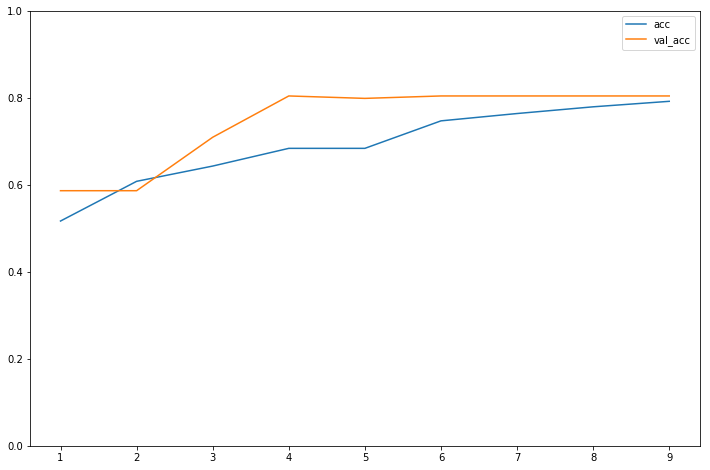

In [23]:
# 訓練データと検証データのエポック毎の正解率の履歴
# 訓練データに対する正解率は79.21%

history_dict2 = history2.history
acc = history_dict2['acc']
val_acc = history_dict2['val_acc']
epochs = range(1, len(acc) + 1)

plt.figure(figsize = (12, 8))
plt.plot(epochs, acc, label='acc')
plt.plot(epochs, val_acc, label='val_acc')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.show()

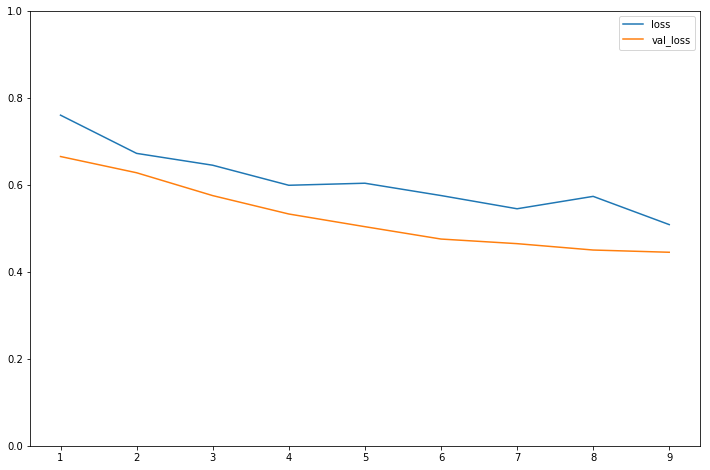

In [32]:
# 訓練データと検証データのエポック毎の損失関数の履歴
# 学習用データと検証用データとの損失関数のギャップが大きいため高バリアンスと考えられデータセットに対してモデルが複雑すぎると考えられる

history_dict2 = history2.history
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize = (12, 8))
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.show()

In [24]:
# テストデータによる予測
NN_y_pred_test2 = model.predict_classes(X_test_norm, batch_size=4) # ミニバッチは訓練時と同じ数値

In [25]:
# テストセットの予測結果とIDをデータフレーム型に変更
my_solution = pd.DataFrame(NN_y_pred_test2, PassengerId, columns = ['Survived'])

# CSVファイルとして書き出し
my_solution.to_csv('data/titanic/titanicNN_3l.csv', index_label = ['PassengerId'])

# kaggleに投稿した結果、正解率は0.77033だった

In [29]:
# 隠れ層を持たない2層ニューラルネットワークによる学習
model = Sequential()
model.add(Dense(32, input_dim=9, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
history = model.fit(X_train2, y_train2, epochs=20, batch_size=1, callbacks=callbacks, validation_data=(X_val, y_val))

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 3s 4ms/step - loss: 0.5341 - acc: 0.7346 - val_loss: 0.4517 - val_acc: 0.8045
Epoch 2/20
712/712 [==============================] - 2s 3ms/step - loss: 0.4435 - acc: 0.7949 - val_loss: 0.4379 - val_acc: 0.8101
Epoch 3/20
712/712 [==============================] - 2s 2ms/step - loss: 0.4285 - acc: 0.8006 - val_loss: 0.4290 - val_acc: 0.8045
Epoch 4/20
712/712 [==============================] - 2s 2ms/step - loss: 0.4252 - acc: 0.8104 - val_loss: 0.4293 - val_acc: 0.8156
Epoch 5/20
712/712 [==============================] - 2s 3ms/step - loss: 0.4151 - acc: 0.8160 - val_loss: 0.4300 - val_acc: 0.8101
Epoch 6/20
712/712 [==============================] - 2s 3ms/step - loss: 0.4130 - acc: 0.8258 - val_loss: 0.4348 - val_acc: 0.8156
Epoch 7/20
712/712 [==============================] - 2s 3ms/step - loss: 0.4126 - acc: 0.8315 - val_loss: 0.4329 - val_acc: 0.8268
Epoch 8/20
712/712 [==========

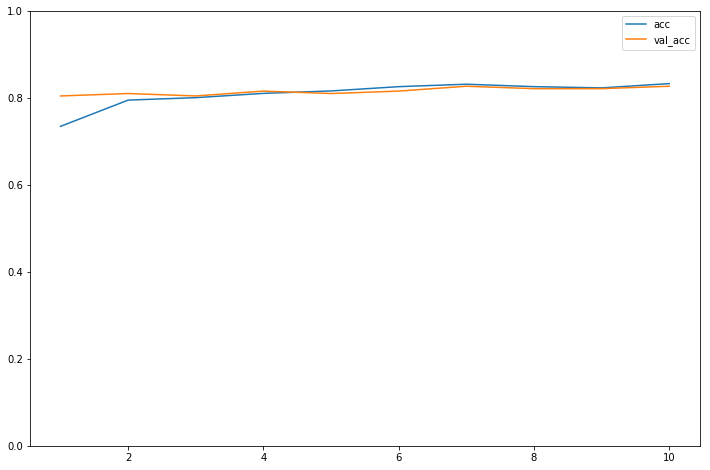

In [33]:
# 訓練データと検証データのエポック毎の正解率の履歴
# 訓練データに対する正解率は83.29%

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
epochs = range(1, len(acc) + 1)

plt.figure(figsize = (12, 8))
plt.plot(epochs, acc, label='acc')
plt.plot(epochs, val_acc, label='val_acc')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.show()

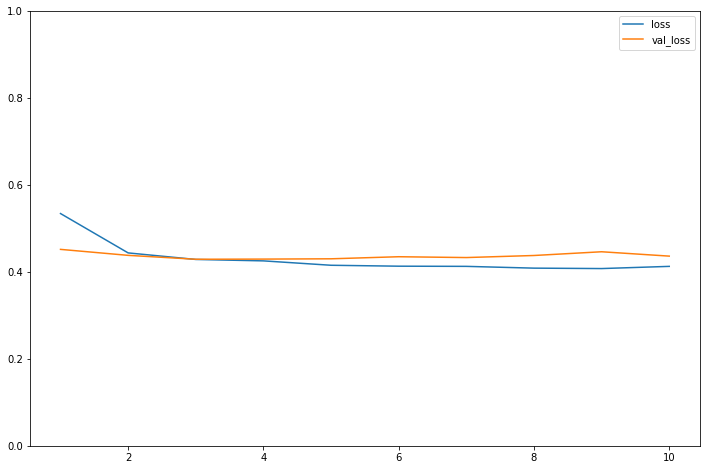

In [34]:
# 訓練データと検証データのエポック毎の損失関数の履歴
# 学習用データと検証用データの損失関数のギャップが少なく、正解率も同等以上なためデータセットに対して適切なモデルだと考えられる
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize = (12, 8))
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.show()

In [122]:
# テストデータによる予測
NN_y_pred_test = model.predict_classes(X_test_norm, batch_size=1) # ミニバッチは訓練時と同じ数値

In [123]:
# テストセットの予測結果とIDをデータフレーム型に変更
my_solution = pd.DataFrame(NN_y_pred_test, PassengerId, columns = ['Survived'])

# CSVファイルとして書き出し
my_solution.to_csv('data/titanic/titanicNN_1l.csv', index_label = ['PassengerId'])

# kaggleに投稿した結果、正解率は0.78947、コンペティションの順位は上位28％だった。
# 隠れ層を持たないモデルのほうが優れた予測ができたためこの分類問題は線形分離可能だと考えられる。